<a href="https://colab.research.google.com/github/Jasmine-404/MUSA6950-AI-for-Urban-Sustainability/blob/main/MUSA_6950_Final_JMF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import ee
import geemap
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

In [ ]:
ee.Authenticate()
ee.Initialize(project='musa-6950-457521')

In [ ]:
# Define Philadelphia boundary
philly = ee.FeatureCollection('TIGER/2018/Counties').filter(ee.Filter.eq('NAME', 'Philadelphia'))


In [ ]:
# Define year range and summer months
years = range(2020, 2025)  # 2020, 2021, 2022, 2023, 2024

# Initialize an empty image collection
landsat_combined = ee.ImageCollection([])

# Loop through each year and collect summer imagery
for year in years:
    start_date = f'{year}-06-01'
    end_date = f'{year}-08-31'

    # Filter Landsat 8 collection for current year's summer
    landsat_year = (ee.ImageCollection('LANDSAT/LC08/C02/T1_L2')
               .filterDate(start_date, end_date)
               .filterBounds(philly)
               .filter(ee.Filter.lt('CLOUD_COVER', 20))  # Filter for low cloud cover
               .sort('CLOUD_COVER')
              )

    # Merge with the combined collection
    landsat_combined = landsat_combined.merge(landsat_year)


# Print information about the combined collection
print(f'Total number of images: {landsat_combined.size().getInfo()}')

Total number of images: 7


In [ ]:
landsat = landsat_combined.median().clip(philly)

In [ ]:
# Display the Landsat image on the map
Map = geemap.Map()
Map.centerObject(philly, 11)  # Center the map on Philadelphia

# Add the Landsat image to the map
image = landsat # Get the first image in the collection
vis_params = {'bands': ['SR_B4', 'SR_B3', 'SR_B2'], 'min': 0, 'max': 30000} # Adjust min/max as needed
Map.addLayer(image, vis_params, 'Landsat 8 Image')
Map


Map(center=[40.00760439369441, -75.13403899470623], controls=(WidgetControl(options=['position', 'transparent_…

In [ ]:
# Fix for the band mismatch error

# First, make sure we're selecting consistent bands from each image
def calculate_indices(image):
    # First select only the bands we need to ensure consistency
    image = image.select(['SR_B2', 'SR_B3', 'SR_B4', 'SR_B5', 'SR_B6', 'ST_B10'])

    # Apply scale factors to surface reflectance bands
    # Each band needs its own scale factor
    optical_bands = ['SR_B2', 'SR_B3', 'SR_B4', 'SR_B5', 'SR_B6']
    scaled = image.select(optical_bands).multiply(0.0000275).add(-0.2)

    # Calculate NDVI (Normalized Difference Vegetation Index)
    ndvi = scaled.normalizedDifference(['SR_B5', 'SR_B4']).rename('NDVI')

    # Calculate NDBI (Normalized Difference Built-up Index)
    ndbi = scaled.normalizedDifference(['SR_B6', 'SR_B5']).rename('NDBI')

    # Calculate MNDWI (Modified Normalized Difference Water Index)
    mndwi = scaled.normalizedDifference(['SR_B3', 'SR_B6']).rename('MNDWI')

    # Calculate SAVI (Soil-Adjusted Vegetation Index)
    savi = scaled.expression(
        '(1 + L) * (NIR - RED) / (NIR + RED + L)',
        {
            'NIR': scaled.select('SR_B5'),
            'RED': scaled.select('SR_B4'),
            'L': 0.5
        }
    ).rename('SAVI')

    # Calculate Land Surface Temperature (LST)
    # Get thermal band and convert to brightness temperature
    thermal = image.select('ST_B10').multiply(0.00341802).add(149.0)

    # Use NDVI to estimate emissivity
    # Here the resolution of LST will automatically be resampled to 30m
    emissivity = ndvi.expression(
        'NDVI < 0.2 ? 0.97 : (NDVI > 0.5 ? 0.99 : 0.97 + 0.02 * ((NDVI - 0.2) / 0.3))',
        {'NDVI': ndvi}
    )

    # Calculate LST in Celsius
    lst = thermal.expression(
        'BT / (1 + (0.00115 * BT / 1.438) * log(e))',
        {
            'BT': thermal,
            'e': emissivity
        }
    ).subtract(273.15).rename('LST')

    # Return a new image with just the indices and LST
    # This ensures consistent band structure across all images
    return ee.Image.cat([scaled, ndvi, ndbi, mndwi, savi, lst])

In [ ]:
# Map indices calculation function over the collection
landsat_with_indices = calculate_indices(landsat)

In [ ]:
# Get the median values to create a composite
composite = landsat_with_indices.clip(philly)

In [ ]:
composite.getInfo()

{'type': 'Image',
 'bands': [{'id': 'SR_B2',
   'data_type': {'type': 'PixelType',
    'precision': 'double',
    'min': -0.2,
    'max': 1.6022125},
   'crs': 'EPSG:4326',
   'crs_transform': [1, 0, 0, 0, 1, 0]},
  {'id': 'SR_B3',
   'data_type': {'type': 'PixelType',
    'precision': 'double',
    'min': -0.2,
    'max': 1.6022125},
   'crs': 'EPSG:4326',
   'crs_transform': [1, 0, 0, 0, 1, 0]},
  {'id': 'SR_B4',
   'data_type': {'type': 'PixelType',
    'precision': 'double',
    'min': -0.2,
    'max': 1.6022125},
   'crs': 'EPSG:4326',
   'crs_transform': [1, 0, 0, 0, 1, 0]},
  {'id': 'SR_B5',
   'data_type': {'type': 'PixelType',
    'precision': 'double',
    'min': -0.2,
    'max': 1.6022125},
   'crs': 'EPSG:4326',
   'crs_transform': [1, 0, 0, 0, 1, 0]},
  {'id': 'SR_B6',
   'data_type': {'type': 'PixelType',
    'precision': 'double',
    'min': -0.2,
    'max': 1.6022125},
   'crs': 'EPSG:4326',
   'crs_transform': [1, 0, 0, 0, 1, 0]},
  {'id': 'NDVI',
   'data_type': {'typ

In [ ]:
# Get the minimum and maximum values of the 'LST' band in the composite image.
lst_min = composite.select('LST').reduceRegion(
    reducer=ee.Reducer.min(),
    geometry=philly,
    scale=30,  # Adjust scale as needed
    maxPixels=1e13
).get('LST')

lst_max = composite.select('LST').reduceRegion(
    reducer=ee.Reducer.max(),
    geometry=philly,
    scale=30,  # Adjust scale as needed
    maxPixels=1e13
).get('LST')

# Print the results
print(f'Minimum LST: {lst_min.getInfo()}')
print(f'Maximum LST: {lst_max.getInfo()}')


Minimum LST: 24.29992756780888
Maximum LST: 60.998325342216106


In [ ]:
# Create a map centered on Philadelphia to view the composite
Map = geemap.Map()
Map.centerObject(philly, 11)

# Add Philadelphia boundary
Map.addLayer(philly, {}, 'Philadelphia Boundary')

# Add indices visualizations
ndvi_vis = {
    'min': -0.8,
    'max': 0.9,
    'palette': ['brown', 'yellow', 'green']
}
Map.addLayer(composite.select('NDVI'), ndvi_vis, 'NDVI')

ndbi_vis = {
    'min': -0.8,
    'max': 0.6,
    'palette': ['blue', 'white', 'red']
}
Map.addLayer(composite.select('NDBI'), ndbi_vis, 'NDBI')

mndwi_vis = {
    'min': -0.7,
    'max': 0.8,
    'palette': ['brown', 'white', 'blue']
}
Map.addLayer(composite.select('MNDWI'), mndwi_vis, 'MNDWI')

savi_vis = {
    'min': 0,
    'max': 0.75,
    'palette': ['brown', 'yellow', 'darkgreen']
}
Map.addLayer(composite.select('SAVI'), savi_vis, 'SAVI')

# Add LST visualization
lst_vis = {
    'min': 24,
    'max': 60,
    'palette': ['blue', 'green', 'yellow', 'orange', 'red']
}
Map.addLayer(composite.select('LST'), lst_vis, 'Land Surface Temperature')

# Add a layer control panel
Map.add_layer_control()

# Display the map
display(Map)

Map(center=[40.00760439369441, -75.13403899470623], controls=(WidgetControl(options=['position', 'transparent_…

In [ ]:
# Define heat risk levels based on LST
def categorize_heat_risk(lst_image):
    # Get LST values for quantile calculation
    # lst_values = lst_image.reduceRegion(
    #     reducer=ee.Reducer.percentile([33, 66]),
    #     geometry=philly,
    #     scale=30,
    #     maxPixels=1e9
    # )

    # low_threshold = ee.Number(lst_values.get('LST_p33'))
    # high_threshold = ee.Number(lst_values.get('LST_p66'))
    low_threshold = 35
    high_threshold = 45

    # Create risk level image (0: low, 1: medium, 2: high)
    risk_levels = ee.Image(0)
    risk_levels = risk_levels.where(lst_image.gt(low_threshold), 1)
    risk_levels = risk_levels.where(lst_image.gt(high_threshold), 2)

    return risk_levels.rename('heat_risk')

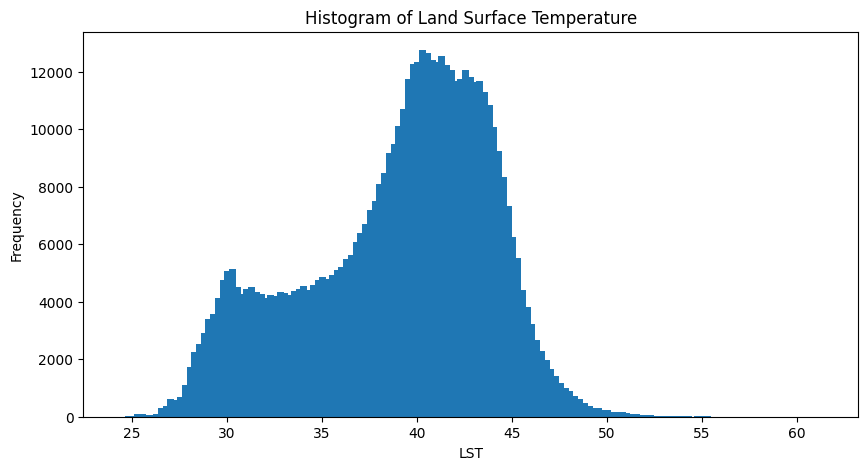

In [ ]:
# Import the matplotlib library
import matplotlib.pyplot as plt

# Function to display histogram
def display_histogram(image, region, band_name, title):
    # Reduce the region to get pixel values.
    histogram = image.reduceRegion(
        reducer=ee.Reducer.histogram(),
        geometry=region,
        scale=30,  # Adjust the scale as needed
        maxPixels=1e13
    )

    # Get the histogram data for the specific band.
    band_histogram = ee.Dictionary(histogram.get(band_name)).getInfo()

    # Extract x and y values for the histogram.
    x_values = band_histogram['bucketMeans']
    y_values = band_histogram['histogram']

    # Create the histogram plot.
    plt.figure(figsize=(10, 5))  # Adjust figure size as needed
    plt.bar(x_values, y_values, width=x_values[1] - x_values[0], align='edge')
    plt.xlabel(band_name)
    plt.ylabel('Frequency')
    plt.title(title)
    plt.show()

# Display the histogram of the LST band
display_histogram(composite, philly, 'LST', 'Histogram of Land Surface Temperature')


In [ ]:
lst_values = composite.reduceRegion(
        reducer=ee.Reducer.percentile([33, 66]),
        geometry=philly,
        scale=30,
        maxPixels=1e9
    )

low_threshold = ee.Number(lst_values.get('LST_p33'))
high_threshold = ee.Number(lst_values.get('LST_p66'))

print(f'Low threshold: {low_threshold.getInfo()}')
print(f'High threshold: {high_threshold.getInfo()}')

Low threshold: 37.376271016920406
High threshold: 41.374784704397506


In [ ]:
# Create heat risk level map
heat_risk = categorize_heat_risk(composite.select('LST'))

In [ ]:
# Add heat risk to composite
final_composite = composite.addBands(heat_risk).clip(philly)

In [ ]:
final_composite

In [ ]:
# Create a map centered on Philadelphia to view the composite
Map = geemap.Map()
Map.centerObject(philly, 11)

# Add Philadelphia boundary
Map.addLayer(philly, {}, 'Philadelphia Boundary')

# Add LST visualization
lst_vis = {
    'min': 27,
    'max': 50,
    'palette': ['blue', 'green', 'yellow', 'orange', 'red']
}
Map.addLayer(final_composite.select('LST'), lst_vis, 'Land Surface Temperature')

# Add LST visualization
risk_vis = {
    'min': 0,
    'max': 2,
    'palette': ['blue','yellow','red']
}
Map.addLayer(final_composite.select('heat_risk'), risk_vis, 'heat risk level')


# Add a layer control panel
Map.add_layer_control()

# Display the map
display(Map)

Map(center=[40.00760439369441, -75.13403899470623], controls=(WidgetControl(options=['position', 'transparent_…

In [ ]:
# Count pixels for each heat risk level
risk_counts = heat_risk.reduceRegion(
    reducer=ee.Reducer.frequencyHistogram(),
    geometry=philly,
    scale=30,
    maxPixels=1e13
)

# Print the results
print(f'Pixel Counts for each heat risk level:\n{risk_counts.getInfo()}')


Pixel Counts for each heat risk level:
{'heat_risk': {'0': 123466.72941176471, '1': 378618.8235294118, '2': 34670.67450980392}}


##Model Building

In [ ]:
# Sample pixels for training data
training_samples = final_composite.stratifiedSample(
    numPoints=5000,
    classBand='heat_risk',
    region=philly,
    scale=30,
    seed=42,
    geometries=True
)


In [ ]:
# Export feature collection to use in ML model
geemap.ee_export_vector(
    training_samples,
    filename='training_samples.geojson',
    selectors=None
)


Generating URL ...
Please wait ...
Data downloaded to /content/training_samples.geojson


In [ ]:
import geopandas as gpd

training_data = gpd.read_file('training_samples.geojson')
print(training_data.head())

  id      SAVI     SR_B2     SR_B3     SR_B4     SR_B5     SR_B6        LST  \
0  0  0.359107  0.064192  0.105965  0.109870  0.336415  0.304102  34.129906   
1  1  0.697859  0.043292  0.069830  0.038672  0.540960  0.213133  34.542098   
2  2  0.063583  0.034438  0.044310  0.036087  0.061415  0.036115  31.516301   
3  3  0.529676  0.025693  0.043375  0.028690  0.332950  0.165695  32.333466   
4  4  0.473195  0.049590  0.073955  0.058362  0.342575  0.208458  32.738777   

       NDVI     MNDWI      NDBI  heat_risk                    geometry  
0  0.507624 -0.483183 -0.050447          0  POINT (-75.00533 40.07721)  
1  0.866562 -0.506436 -0.434731          0    POINT (-75.184 39.99825)  
2  0.259763  0.101896 -0.259407          0  POINT (-75.19532 39.99448)  
3  0.841334 -0.585067 -0.335419          0  POINT (-75.21338 40.05916)  
4  0.708870 -0.476263 -0.243393          0  POINT (-75.20233 40.00526)  


In [ ]:

# Prepare features and target
features = ['SR_B2', 'SR_B3', 'SR_B4', 'SR_B5', 'NDVI', 'NDBI', 'MNDWI', 'SAVI']
# features = ['SR_B2', 'SR_B3', 'SR_B4', 'SR_B5', 'NDVI', 'NDBI', 'SAVI']

X = training_data[features].values
y = training_data['heat_risk'].values.astype(int)

In [ ]:
X.shape

(15000, 8)

In [ ]:
# Reshape features for CNN (adding channel dimension)
X_reshaped = X.reshape(X.shape[0], 1, 8, 1)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_reshaped, y, test_size=0.3, random_state=42, stratify=y)

# One-hot encode targets
y_train_one_hot = tf.keras.utils.to_categorical(y_train, 3)
y_test_one_hot = tf.keras.utils.to_categorical(y_test, 3)

In [ ]:
X_reshaped.shape

(15000, 1, 8, 1)

In [ ]:
from tensorflow.keras.optimizers import Adagrad

# model building
model1 = Sequential([
    # first convolution layer
    Conv2D(16, (2, 2), activation='tanh', padding='same', input_shape=(1, 8, 1)),
    # second
    Conv2D(32, (1, 1), activation='tanh'),
    # third
    Conv2D(32, (1, 1), activation='tanh'),
    # forth
    Conv2D(64, (1, 1), activation='tanh'),

    Flatten(),

    # first fully connected layer
    Dense(128, activation='tanh'),
    Dropout(0.3),

    # second
    Dense(64, activation='tanh'),

    # third fully connected layer + output layer
    Dense(3, activation='softmax')
])

model1.compile(
    optimizer=Adagrad(learning_rate=0.003),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history1 = model1.fit(
    X_train, y_train_one_hot,
    epochs=30,
    batch_size=32,
    validation_data=(X_test, y_test_one_hot),
    callbacks=[EarlyStopping(patience=10, restore_best_weights=True)]
)

Epoch 1/30
329/329 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.5271 - loss: 1.0063 - val_accuracy: 0.7153 - val_loss: 0.7315
Epoch 2/30
329/329 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.7083 - loss: 0.6984 - val_accuracy: 0.7449 - val_loss: 0.6059
Epoch 3/30
329/329 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.7248 - loss: 0.6256 - val_accuracy: 0.7384 - val_loss: 0.5898
Epoch 4/30
329/329 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.7257 - loss: 0.6148 - val_accuracy: 0.7533 - val_loss: 0.5776
Epoch 5/30
329/329 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.7343 - loss: 0.5990 - val_accuracy: 0.7478 - val_loss: 0.5737
Epoch 6/30
329/329 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.7325 - loss: 0.6047 - val_accuracy: 0.7580 - val_loss: 0.5713
Epoch 7/30
329/329 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.7375 - loss: 0.5938 - val_accuracy: 0.7589 - val_loss: 0.5671
Epoch 8/30
329/329 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.7391 - loss: 0.5924 - val_accuracy: 0.

In [ ]:
# from tensorflow.keras.utils import plot_model

# plot_model(model1, to_file='model1_structure.png', show_shapes=True, show_layer_names=True, dpi=100)
model1.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 1, 8, 16)       │            80 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 1, 8, 32)       │           544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 1, 8, 32)       │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 1, 8, 64)       │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 155,816 (608.66 KB)

 Trainable params: 77,907 (304.32 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 77,909 (304.34 KB)

141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
              precision    recall  f1-score   support

           0       0.86      0.88      0.87      1500
           1       0.71      0.60      0.65      1500
           2       0.74      0.85      0.79      1500

    accuracy                           0.78      4500
   macro avg       0.77      0.78      0.77      4500
weighted avg       0.77      0.78      0.77      4500

Confusion Matrix:
[[1323  141   36]
 [ 206  894  400]
 [   6  221 1273]]


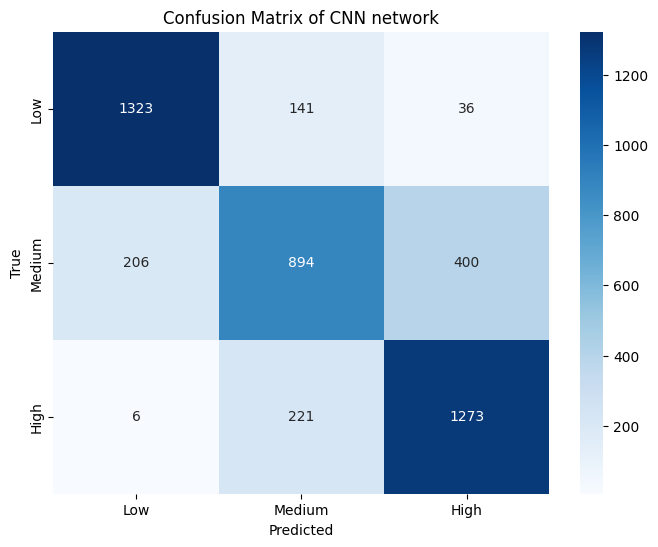

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report

# Make predictions on the test set
y_pred_probs = model1.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)

# Calculate the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Calculate and print the classification report
print(classification_report(y_test, y_pred))

# Print the confusion matrix
print("Confusion Matrix:")
print(cm)

# You can also visualize the confusion matrix using seaborn or matplotlib
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Low', 'Medium', 'High'],
            yticklabels=['Low', 'Medium', 'High'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix of CNN network')
plt.show()


In [ ]:
test_loss, test_acc = model1.evaluate(X_test, y_test_one_hot)
print(f"Test accuracy: {test_acc:.4f}")

141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7792 - loss: 0.5234
Test accuracy: 0.7756


## Random Forest

Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.87      0.87      1524
           1       0.68      0.61      0.64      1492
           2       0.74      0.82      0.78      1484

    accuracy                           0.77      4500
   macro avg       0.76      0.77      0.76      4500
weighted avg       0.76      0.77      0.76      4500



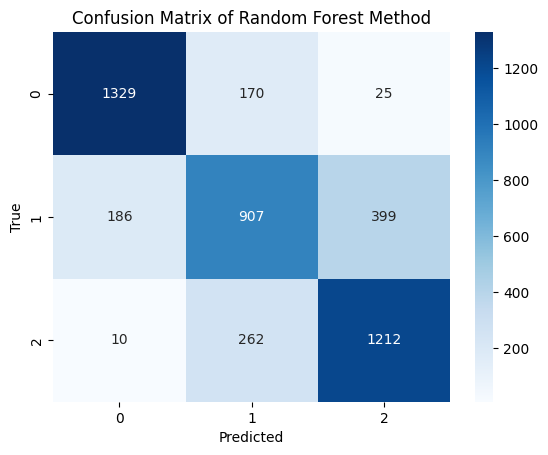

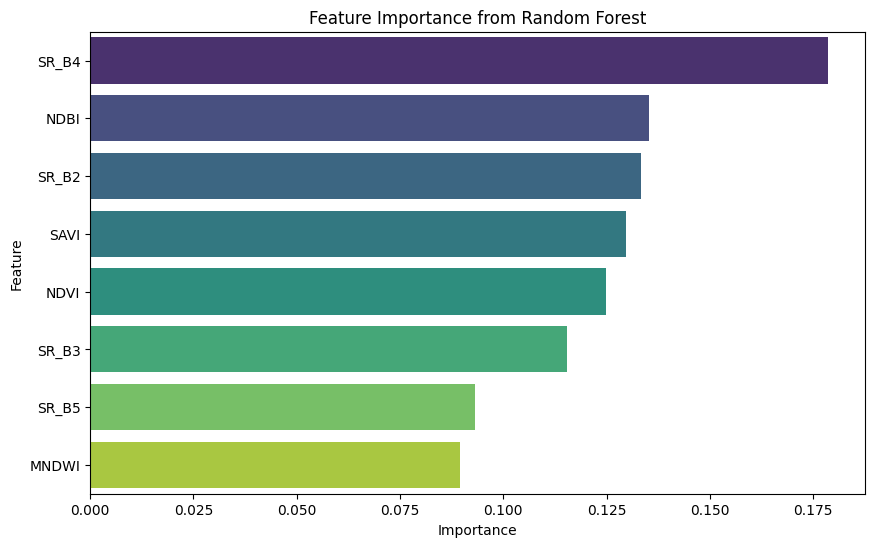

In [ ]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Prepare features and target
features = ['SR_B2', 'SR_B3', 'SR_B4', 'SR_B5', 'NDVI', 'NDBI', 'MNDWI', 'SAVI']
# features = ['SR_B2', 'SR_B3', 'SR_B4', 'SR_B5', 'NDVI', 'NDBI', 'SAVI']
X = training_data[features].values
y = training_data['heat_risk'].values.astype(int)

# train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# build rf model
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# predict
y_pred = rf.predict(X_test)

# confusion matrix report
print("Classification Report:\n", classification_report(y_test, y_pred))

conf_mat = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix of Random Forest Method')
plt.show()

# view var importance
importances = rf.feature_importances_
importance_df = pd.DataFrame({'Feature': features, 'Importance': importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# visualize
plt.figure(figsize=(10,6))
sns.barplot(data=importance_df, x='Importance', y='Feature', palette='viridis')
plt.title('Feature Importance from Random Forest')
plt.show()
